In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from umap import UMAP
import plotly.express as px
from umap.umap_ import nearest_neighbors
import sklearn.cluster as cluster
from collections import defaultdict
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from collections import Counter
import plotly.io as pio
from sklearn.neighbors import NearestNeighbors
import time
from skimage.filters import threshold_minimum
%matplotlib inline

In [2]:
# normal_cell = pd.read_csv('binned_read_counts.merged.tsv.txt',sep='\t')
# normal_variant = pd.read_csv('variant_data.filt.tsv.txt', sep='\t')

In [65]:
bin_count_data = pd.read_csv('data/binned_read_counts_autosomes_filtered.tsv.txt', sep='\t')
bin_count_normal = pd.read_csv('data/normal_sample_autosomes.tsv.txt', sep='\t')
snv_bin_mapping = pd.read_csv('data/snv_bin_mapping_autosomes_filtered.csv', names=['mutation_id', 'chr', 'bin'])

In [66]:
col_names = ['chr', 'mutation_id', 'cell_id', 'base', 'var', 'total', 'copies']
variant_count_data = pd.read_csv('data/variant_data_autosomes_filtered.tsv.txt', sep="\t",header=None, names=col_names, skiprows=[0])

In [67]:
variant_count_data.drop('copies', inplace=True, axis=1)

In [68]:
def get_data(bin_count_data, bin_count_normal,variant_count_data,snv_bin_mapping):
    data = {}
    variant_count_data['chr_mutation'] = variant_count_data['chr'].astype('str') + "_" + variant_count_data['mutation_id'].astype(str)
    cell_labels = np.sort(variant_count_data['cell_id'].unique())
    mut_labels = np.sort(variant_count_data['chr_mutation'].unique())
    n = cell_labels.shape[0]
    m = mut_labels.shape[0]
    cells = np.arange(n,dtype="int")
    muts = np.arange(m, dtype="int")
    cell_series = pd.Series(data=cells, index= cell_labels)
    cell_lookup = pd.Series(data=cell_labels, index=cells)
    mut_series = pd.Series(data=muts, index =mut_labels)
    data["mutation_mapping"] = mut_series
    data["cell_mapping"] = cell_series
    mut_lookup = pd.Series(data=mut_labels, index=muts)
    variant_count_data['mutation'] = mut_series[variant_count_data['chr_mutation']].values
    variant_count_data['cell'] = cell_series[variant_count_data['cell_id']].values
    variant_count_data= variant_count_data.set_index(["cell", "mutation"])
    snv_bin_mapping['chr_mutation'] = snv_bin_mapping['chr'].astype('str') + "_" + snv_bin_mapping['mutation_id'].astype(str)
    snv_bin_mapping['mutation'] = mut_series.loc[snv_bin_mapping['chr_mutation']].values
    snv_bin_mapping = snv_bin_mapping.set_index("mutation").sort_index()
    data['snv_bin_mapping'] = snv_bin_mapping
    bin_count_data['cell_index'] = cell_series[bin_count_data['cell']].values
    bin_count_data.sort_values(by=['cell_index'])
    bin_count_data.drop(['cell', 'cell_index'], inplace=True, axis=1)
    bin_count_raw =   bin_count_data.div(bin_count_data.sum(axis=1), axis=0)
    bin_count = bin_count_data.to_numpy()
    bin_count_raw = bin_count_raw.to_numpy()
    cells = bin_count_normal['cell']
    bin_count_normal = bin_count_normal.drop(['cell'], axis=1)
    bin_count_normal=   bin_count_normal.div(bin_count_normal.sum(axis=1), axis=0)
    bin_normal = bin_count_normal.median()
    bins = np.arange(0, bin_normal.shape[0])
    bin_mapping = pd.Series(data=bin_normal.index, index=bins)
    bin_locs = bin_mapping.to_list()
    chromosomes = [c.split(".")[0] for c in bin_locs]
    chromosomes = [int(c[3:]) for c in chromosomes]
    chrom_series = pd.Series(chromosomes, bin_mapping.index)
    data['chrom_bin_mapping'] = chrom_series
    bin_normal = pd.Series(data=bin_normal.values, index=bins)
    baseline = bin_normal.values
    rdr = bin_count_raw/baseline[ None, :]
    data['RDR'] = rdr
    return data

In [112]:
def create_labels(n_obs, n_sim):
    labels_0 = np.zeros(n_obs, dtype=int)
    labels_1 = np.ones(n_sim, dtype=int)
    labels = np.concatenate((labels_0, labels_1))
    
    return labels

In [113]:
def simulate_doublets(bin_count_data, sim_doublet_ratio = 0.5):
    obs = bin_count_data.to_numpy()
    n_obs = len(obs)
#     sim_doublet_ratio = 0.1
    n_sim = int(n_obs * sim_doublet_ratio)
    pair_ix = np.random.randint(0, n_obs, size=(n_sim, 2))
    temp = obs[pair_ix[:,0]] + obs[pair_ix[:,1]]
    count_data = np.concatenate((obs,temp),axis=0)
    bin_count_data_new = pd.DataFrame(count_data, columns=bin_count_data.columns.to_list())
    labels = create_labels(n_obs, n_sim)
    return bin_count_data_new, labels

In [71]:
def dimension_reduction(rdr, dimension=5):
    reducer = UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=dimension, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )
    rdr_trans = reducer.fit_transform(rdr)
    
    return rdr_trans

In [72]:
def get_knn_graph(X, k=5, dist_metric='euclidean', approx=False, return_edges=True):
    t0 = time.time()
    if approx:
        try:
            from annoy import AnnoyIndex
        except:
            approx = False
            print('Could not find library "annoy" for approx. nearest neighbor search')
    if approx:
        #print('Using approximate nearest neighbor search')

        if dist_metric == 'cosine':
            dist_metric = 'angular'
        npc = X.shape[1]
        ncell = X.shape[0]
        annoy_index = AnnoyIndex(npc, metric=dist_metric)

        for i in range(ncell):
            annoy_index.add_item(i, list(X[i,:]))
        annoy_index.build(10) # 10 trees

        knn = []
        for iCell in range(ncell):
            knn.append(annoy_index.get_nns_by_item(iCell, k + 1)[1:])
        knn = np.array(knn, dtype=int)

    else:
        #print('Using sklearn NearestNeighbors')

        if dist_metric == 'cosine':
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric, algorithm='brute').fit(X)
        else:
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric).fit(X)
        knn = nbrs.kneighbors(return_distance=False)

    if return_edges:
        links = set([])
        for i in range(knn.shape[0]):
            for j in knn[i,:]:
                links.add(tuple(sorted((i,j))))

        t_elapse = time.time() - t0
        #print('kNN graph built in %.3f sec' %(t_elapse))

        return links, knn
    return knn

In [132]:
def nearest_neighbor_classifier(embedding, doub_labels, k=50, use_approx_nn=True, distance_metric='euclidean', exp_doub_rate=0.1, stdev_doub_rate=0.03, get_neighbor_parents = False, parent_cells = None):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)
    
     # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(k * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors = get_knn_graph(embedding, k=k_adj, dist_metric=distance_metric, approx=use_approx_nn, return_edges=False)

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    doub_neigh_mask = doub_labels[neighbors] == 1
    n_sim_neigh = doub_neigh_mask.sum(1)
    n_obs_neigh = doub_neigh_mask.shape[1] - n_sim_neigh

    rho = exp_doub_rate
    r = n_sim / float(n_obs)
    nd = n_sim_neigh.astype(float)
    ns = n_obs_neigh.astype(float)
    N = float(k_adj)

    # Bayesian
    q=(nd+1)/(N+2)
    Ld = q*rho/r/(1-rho-q*(1-rho-rho/r))
    print(Ld)

    se_q = np.sqrt(q*(1-q)/(N+3))
    se_rho = stdev_doub_rate

    se_Ld = q*rho/r / (1-rho-q*(1-rho-rho/r))**2 * np.sqrt((se_q/q*(1-rho))**2 + (se_rho/rho*(1-q))**2)

    doublet_scores_obs = Ld[doub_labels == 0]
    doublet_scores_sim = Ld[doub_labels == 1]
    doublet_errors_obs = se_Ld[doub_labels==0]
    doublet_errors_sim = se_Ld[doub_labels==1]

    # get parents of doublet neighbors, if requested
    neighbor_parents = None
    if get_neighbor_parents:
        parent_cells = self.doublet_parents_
        neighbors = neighbors - n_obs
        neighbor_parents = []
        for iCell in range(n_obs):
            this_doub_neigh = neighbors[iCell,:][neighbors[iCell,:] > -1]
            if len(this_doub_neigh) > 0:
                this_doub_neigh_parents = np.unique(parent_cells[this_doub_neigh,:].flatten())
                neighbor_parents.append(this_doub_neigh_parents)
            else:
                neighbor_parents.append([])
        self.doublet_neighbor_parents_ = np.array(neighbor_parents)
    return doublet_scores_obs, doublet_scores_sim, doublet_errors_obs, doublet_errors_sim

In [146]:
def plot_histogram(doublet_scores_obs_, doublet_scores_sim_, threshold_=None, scale_hist_obs='log', scale_hist_sim='linear', fig_size = (8,3)):
        ''' Plot histogram of doublet scores for observed transcriptomes and simulated doublets 
        The histogram for simulated doublets is useful for determining the correct doublet 
        score threshold. To set threshold to a new value, T, run call_doublets(threshold=T).

        '''

        fig, axs = plt.subplots(1, 2, figsize = fig_size)
        
        if not threshold_:
            threshold_ = threshold_minimum(doublet_scores_sim_)

        ax = axs[0]
        ax.hist(doublet_scores_obs_, np.linspace(0, 1, 50), color='gray', linewidth=0, density=True)
        ax.set_yscale(scale_hist_obs)
        yl = ax.get_ylim()
        ax.set_ylim(yl)
        ax.plot(threshold_ * np.ones(2), yl, c='black', linewidth=1)
        ax.set_title('Observed cells')
        ax.set_xlabel('Doublet score')
        ax.set_ylabel('Prob. density')

        ax = axs[1]
        ax.hist(doublet_scores_sim_, np.linspace(0, 1, 50), color='gray', linewidth=0, density=True)
        ax.set_yscale(scale_hist_sim)
        yl = ax.get_ylim()
        ax.set_ylim(yl)
        ax.plot(threshold_ * np.ones(2), yl, c = 'black', linewidth = 1)
        ax.set_title('Simulated doublets')
        ax.set_xlabel('Doublet score')
        ax.set_ylabel('Prob. density')

        fig.tight_layout()

        return fig, axs

In [152]:
def call_doublets(doublet_scores_obs_, doublet_scores_sim_, doublet_errors_obs_, expected_doublet_rate=0.1, threshold=None, verbose=True):
        ''' Call trancriptomes as doublets or singlets

        Arguments
        ---------
        threshold : float, optional (default: None) 
            Doublet score threshold for calling a transcriptome
            a doublet. If `None`, this is set automatically by looking
            for the minimum between the two modes of the `doublet_scores_sim_`
            histogram. It is best practice to check the threshold visually
            using the `doublet_scores_sim_` histogram and/or based on 
            co-localization of predicted doublets in a 2-D embedding.

        verbose : bool, optional (default: True)
            If True, print summary statistics.

        Sets
        ----
        predicted_doublets_, z_scores_, threshold_,
        detected_doublet_rate_, detectable_doublet_fraction, 
        overall_doublet_rate_
        '''

        if threshold is None:
            # automatic threshold detection
            # http://scikit-image.org/docs/dev/api/skimage.filters.html
            from skimage.filters import threshold_minimum
            try:
                threshold = threshold_minimum(doublet_scores_sim_)
                if verbose:
                    print("Automatically set threshold at doublet score = {:.2f}".format(threshold))
            except:
                predicted_doublets_ = None
                if verbose:
                    print("Warning: failed to automatically identify doublet score threshold. Run `call_doublets` with user-specified threshold.")
                return predicted_doublets_

        Ld_obs = doublet_scores_obs_
        Ld_sim = doublet_scores_sim_
        se_obs = doublet_errors_obs_
        Z = (Ld_obs - threshold) / se_obs
        predicted_doublets_ = Ld_obs > threshold
        z_scores_ = Z
        threshold_ = threshold
        detected_doublet_rate_ = (Ld_obs>threshold).sum() / float(len(Ld_obs))
        detectable_doublet_fraction_ = (Ld_sim>threshold).sum() / float(len(Ld_sim))
        overall_doublet_rate_ = detected_doublet_rate_ / detectable_doublet_fraction_

        if verbose:
            print('Detected doublet rate = {:.1f}%'.format(100*detected_doublet_rate_))
            print('Estimated detectable doublet fraction = {:.1f}%'.format(100*detectable_doublet_fraction_))
            print('Overall doublet rate:')
            print('\tExpected   = {:.1f}%'.format(100*expected_doublet_rate))
            print('\tEstimated  = {:.1f}%'.format(100*overall_doublet_rate_))
            
        return predicted_doublets_, threshold_

In [166]:
def plot(rdr_trans, labels=None, x=None, y=None, name=None):
    fig = plt.figure()
    plt.scatter(rdr_trans[:,0], rdr_trans[:,1], c=labels, s=0.1, cmap='Spectral')
#     plt.legend()
    if x:
        plt.xlabel(f'{x}')
    if y:
        plt.xlabel(f'{y}')
    if name:
        plt.savefig(f'{name}.png')
    return fig

In [81]:
data=get_data(pd.concat([bin_count_data, bin_count_normal]),bin_count_normal,variant_count_data,snv_bin_mapping)

In [82]:
rdr = data['RDR']

In [83]:
rdr

array([[0.79401484, 0.84294879, 0.82388614, ..., 1.1263762 , 1.11170634,
        1.01939827],
       [0.75533629, 0.76328208, 0.82766831, ..., 1.03843526, 1.01914688,
        1.01547299],
       [0.79334036, 0.74353755, 0.80360424, ..., 0.99974793, 1.03361258,
        0.94109451],
       ...,
       [0.98984869, 1.02283107, 0.95970166, ..., 1.03044672, 0.90277654,
        1.04499165],
       [1.02149711, 1.05526537, 0.97006989, ..., 1.03620337, 1.08257573,
        1.13908428],
       [1.04943216, 1.06336913, 1.04789101, ..., 1.01274198, 0.98485357,
        1.10893789]])

In [84]:
rdr_trans = dimension_reduction(rdr)

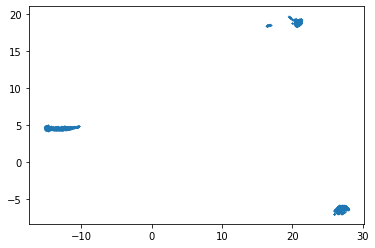

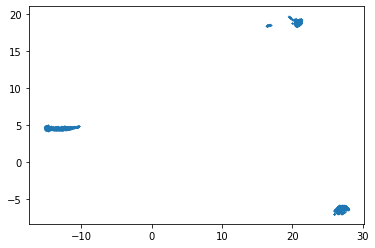

In [162]:
plot(rdr_trans, name='dr_observed')

In [114]:
obs_sim, labels = simulate_doublets(pd.concat([bin_count_data, bin_count_normal]))

In [115]:
data_s = get_data(obs_sim,bin_count_normal, variant_count_data,snv_bin_mapping)

In [116]:
rdr_s = data_s['RDR']

In [118]:
rdr_s_trans = dimension_reduction(rdr_s)

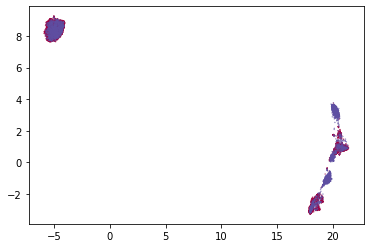

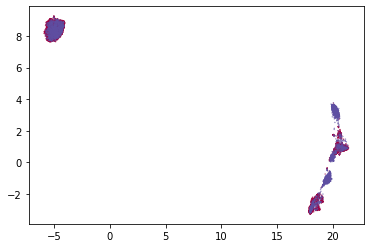

In [167]:
plot(rdr_s_trans, labels, name='dr_combined')

In [135]:
doublet_scores_obs, doublet_scores_sim, doublet_errors_obs, doublet_errors_sim = nearest_neighbor_classifier(rdr_s, labels)

Could not find library "annoy" for approx. nearest neighbor search
[0.05924037 0.31613628 0.10715474 ... 0.89286903 0.13026618 0.94410594]


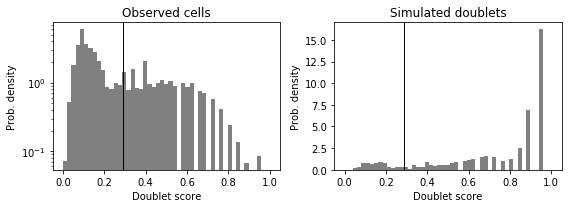

In [169]:
fig1, ax = plot_histogram(doublet_scores_obs, doublet_scores_sim)

In [175]:
fig1.savefig('score_dis_df.png')

In [158]:
predicted_doublets, threshold = call_doublets(doublet_scores_obs, doublet_scores_sim, doublet_errors_obs, threshold=0.6)

Detected doublet rate = 8.1%
Estimated detectable doublet fraction = 68.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.9%


In [161]:
predicted_doublets

array([False, False, False, ..., False, False, False])

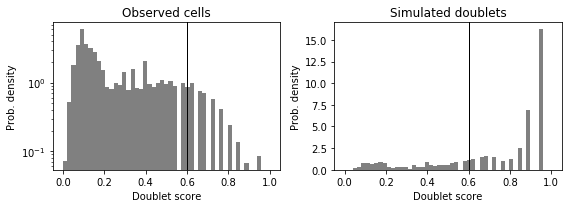

In [173]:
fig2, ax = plot_histogram(doublet_scores_obs, doublet_scores_sim, threshold_=threshold)

In [176]:
fig2.savefig('score_dis.png')

In [92]:
def inverse_cluster(data, cluster_labels):
    res = defaultdict(list)
    for i in range(len(data)):
        res[cluster_labels[i]] += [(i,data[i])]
    return res

In [114]:
def inverse_cluster_cells(data, cluster_labels):
    res = defaultdict(list)
    for i in range(len(data)):
        res[cluster_labels[i]] += [i]
    return res